In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from scipy import misc
import numpy as np
import glob
import matplotlib.pyplot as plt
from network import Network
from circle_generator import Circles
from dataset import SegmentationDataset
from loss import SegmentationLoss, ImageLoss

### Train on HeLa dataset

In [2]:
def train(num_epochs, batch_size, num_workers):
    transformed_dataset = SegmentationDataset(path_to_images='./datasets/HeLa/01/',
                                              path_to_segm='./datasets/HeLa/01_GT/SEG/', 
                                              transform=transforms.Compose([
                                                  ToTensor(), 
                                                  Normalize()
                                              ]))
    dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers)
    
    net = network()
    segm_loss = SegmentationLoss()
    img_loss = ImageLoss()
    z_input = Variable(torch.randn(84, 1, 512, 512), requires_grad=True)
    optimizer = optim.Adam([z_input] + list(net.parameters()), lr=0.1)
    
    for epoch in range(num_epochs):
        
        for data in dataloader:
            gt_img = Variable(data['image'])
            idx = data['idx']
            
            optimizer.zero_grad()
            img, segm = net(z_input[idx])
            loss = img_loss(img, gt_img)
            loss.backward()
            optimizer.step()
        

In [ ]:
train(1, 2, 1)

### circles example

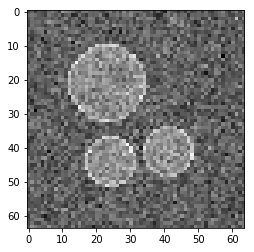

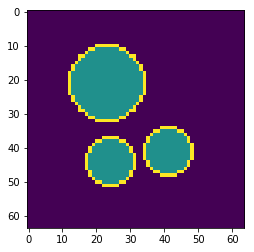

In [3]:
predata = Circles(radius=12, bg_color=0, perim_color=0.2, circle_color=0.1,
                  size=(64, 64), n_obj=5, var_n_obj=1, var_size=5, maxover=0)
x, y = predata.get_train_batch(1)
plt.imshow(x[0, 0],cmap='gray')
plt.figure()
plt.imshow(y[0])
plt.show()

## Training circles

In [4]:
def show_image_segm(gen_img, gen_segm, real_img, real_segm):
    for i, image in enumerate(gen_img):
        f, axarr = plt.subplots(2, 2, figsize=(10, 10))
        axarr[0, 0].imshow(image[0], cmap='gray')
        axarr[0, 0].set_title('Gen image')
        axarr[0, 1].imshow(real_img[i][0], cmap='gray')
        axarr[0, 1].set_title('Real image')
        axarr[1, 0].imshow(np.argmax(gen_segm[i], 0))
        axarr[1, 0].set_title('Gen segmentation')
        axarr[1, 1].imshow(real_segm[i])
        axarr[1, 1].set_title('Real segmentation')
    plt.show()

### Generate train batch

In [5]:
batch_size = 30

In [6]:
train_images, train_segmentation = predata.get_train_batch(batch_size)

In [7]:
train_images = Variable(torch.from_numpy(train_images).float(), requires_grad=False)
train_segmentation = Variable(torch.from_numpy(train_segmentation), requires_grad=False)

In [8]:
net = Network(num_z_channels=3, num_classes=3)
segm_loss = SegmentationLoss()
img_loss = ImageLoss()

### create latent variable

In [9]:
z_input = Variable(torch.randn(batch_size, 3, 64, 64), requires_grad=True)

### Training

In [10]:
def normalize_z(z):
    norm_z = z.data.norm(dim=1, p=2)
    norm_z = norm_z.unsqueeze(dim=1)
    norm_z = norm_z.repeat(1, 3, 1, 1)
    norm_z.clamp_(min=1.0)
    z.data = z.data / norm_z

In [11]:
optimizer = optim.Adam([z_input] + list(net.parameters()), lr=0.001)

loss_epoch = []
num_epochs = 200

for epoch in range(num_epochs):
    normalize_z(z_input)
    optimizer.zero_grad()   
    img, segm = net(z_input)
    loss = segm_loss(segm, train_segmentation) + 1000 * img_loss(img, train_images)
    loss_epoch.append(loss.data)
    loss.backward()
    optimizer.step()
    print('epoch - {}, loss - {}'.format(epoch, loss.data.numpy()[0]))

normalize_z(z_input)

epoch - 0, loss - 6.774509429931641
epoch - 1, loss - 17.82633399963379
epoch - 2, loss - 6.3011698722839355
epoch - 3, loss - 6.225338935852051
epoch - 4, loss - 6.256103992462158
epoch - 5, loss - 6.136503219604492
epoch - 6, loss - 6.033555030822754
epoch - 7, loss - 6.095725059509277
epoch - 8, loss - 5.996728420257568
epoch - 9, loss - 5.945581436157227
epoch - 10, loss - 5.92819356918335
epoch - 11, loss - 5.900089740753174
epoch - 12, loss - 5.851030349731445
epoch - 13, loss - 5.7997612953186035
epoch - 14, loss - 5.778750419616699
epoch - 15, loss - 5.776384353637695
epoch - 16, loss - 5.755331516265869
epoch - 17, loss - 5.752577781677246
epoch - 18, loss - 5.765356540679932
epoch - 19, loss - 5.761806011199951
epoch - 20, loss - 5.739866256713867
epoch - 21, loss - 5.721930503845215
epoch - 22, loss - 5.712690353393555
epoch - 23, loss - 5.694180011749268
epoch - 24, loss - 5.689747333526611
epoch - 25, loss - 5.686092853546143
epoch - 26, loss - 5.675259113311768
epoch - 27

In [23]:
torch.save(net.state_dict(), './model')

### learning

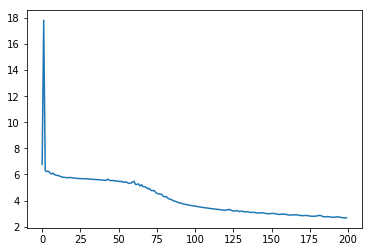

In [12]:
plt.plot(loss_epoch)
plt.show()

In [13]:
img, segm = net(z_input)

### Results 

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


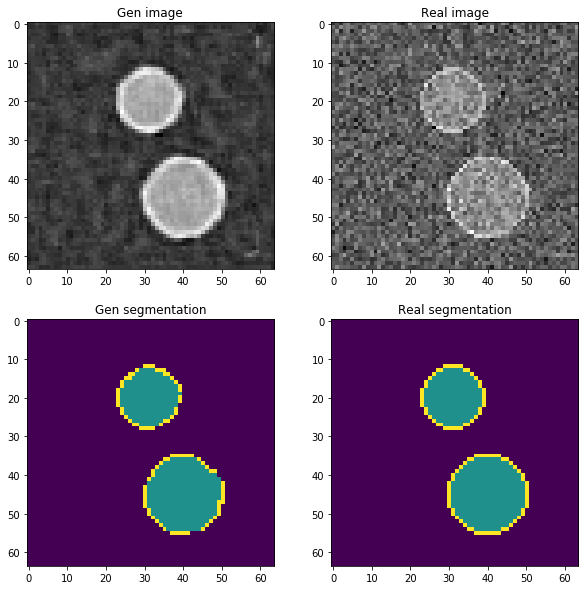

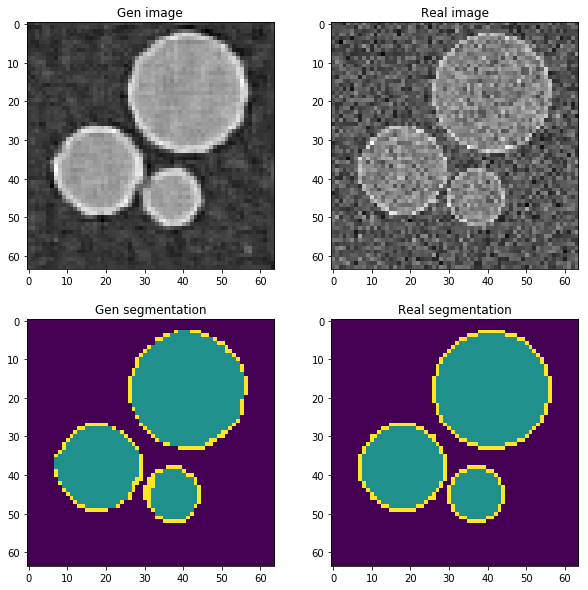

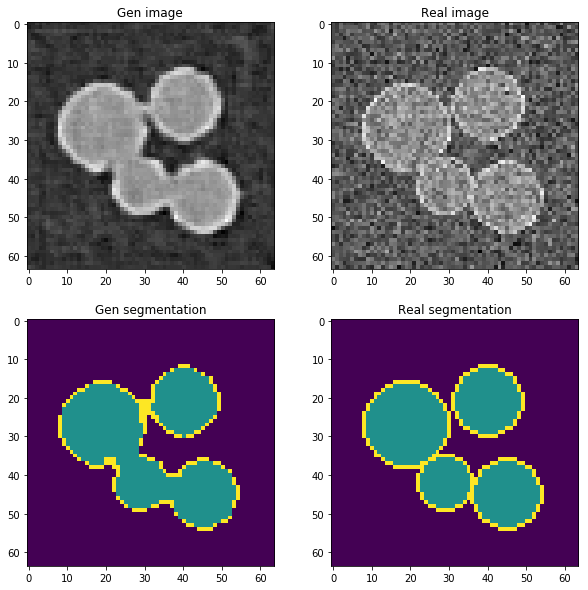

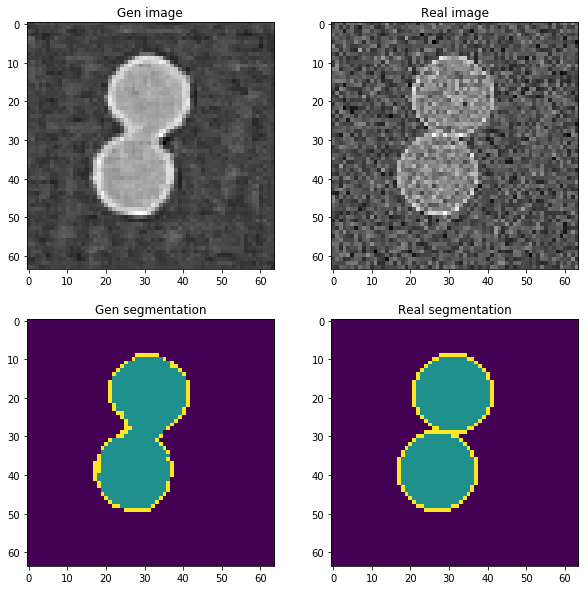

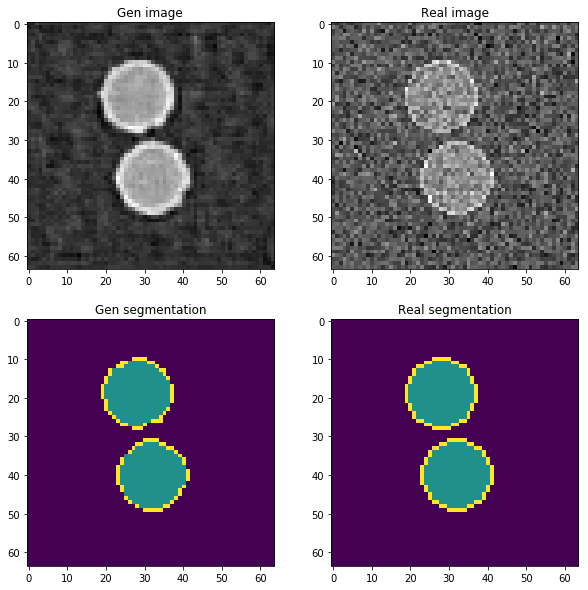

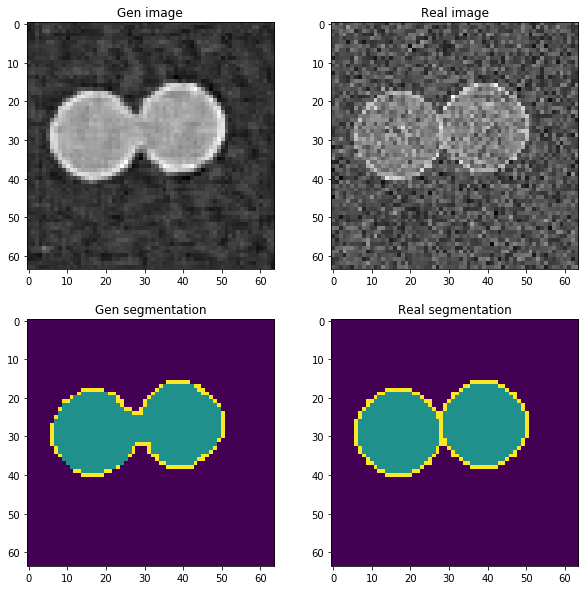

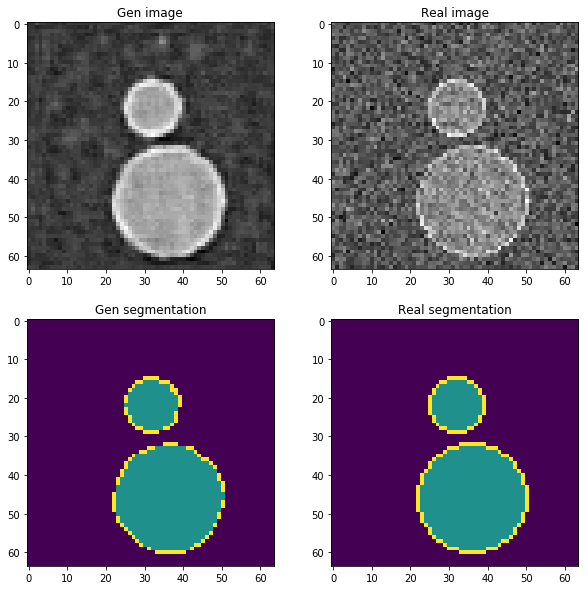

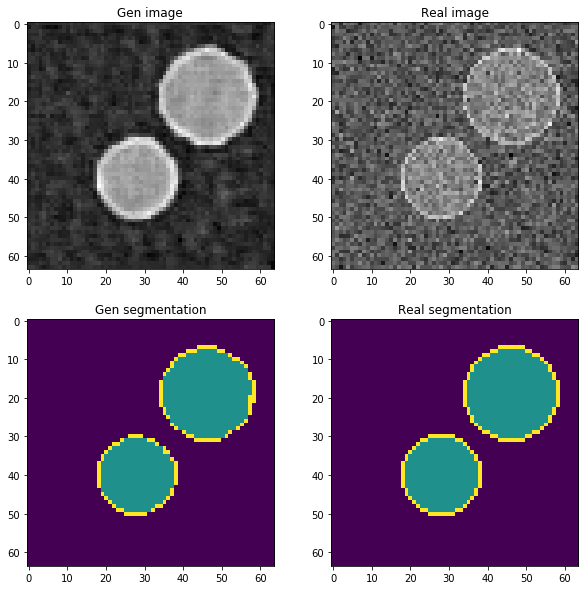

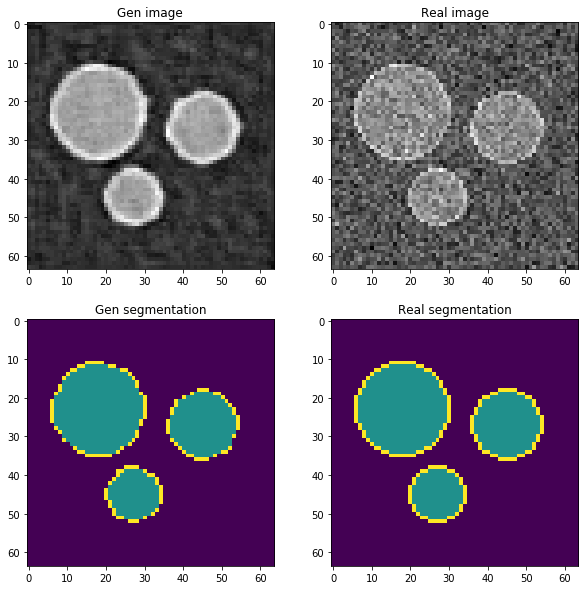

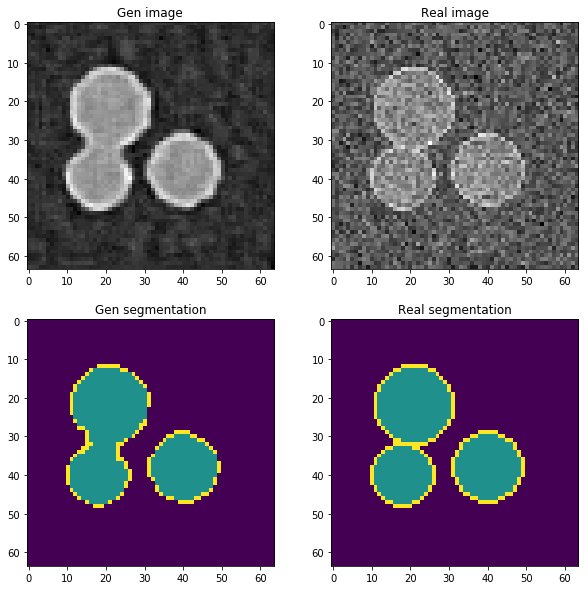

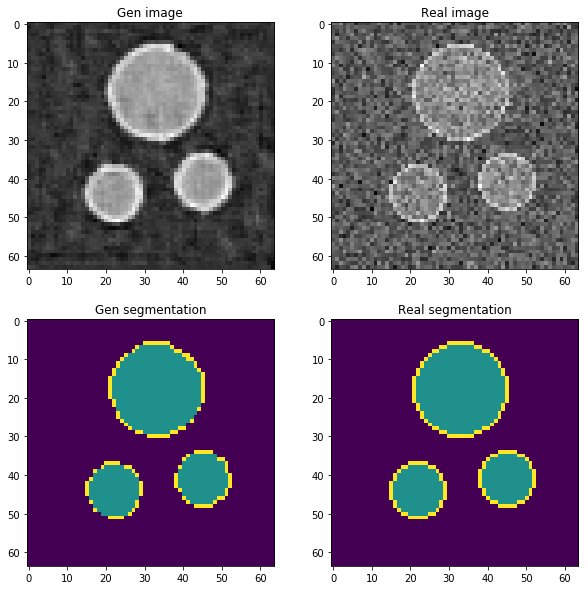

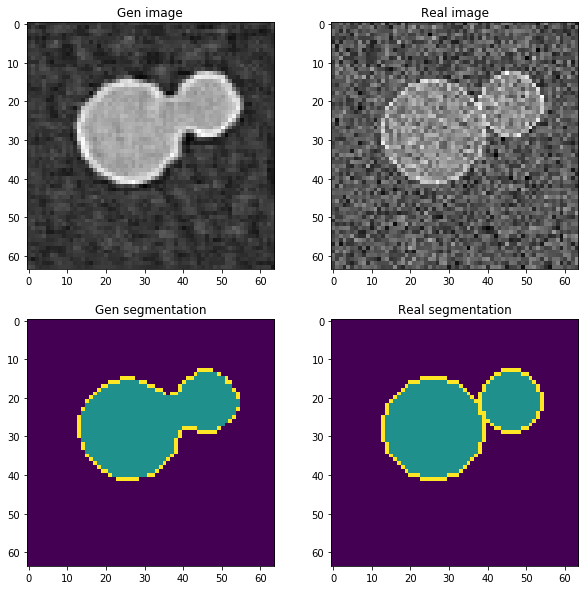

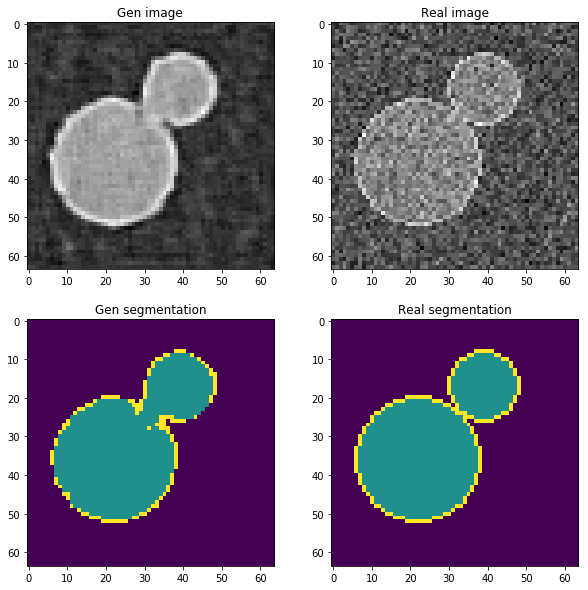

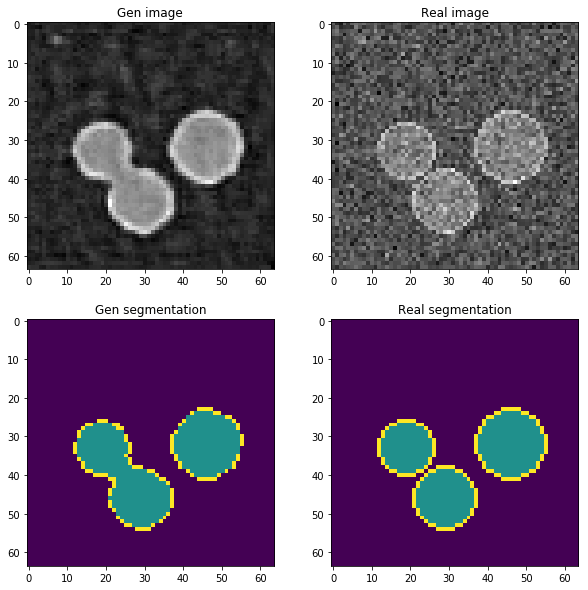

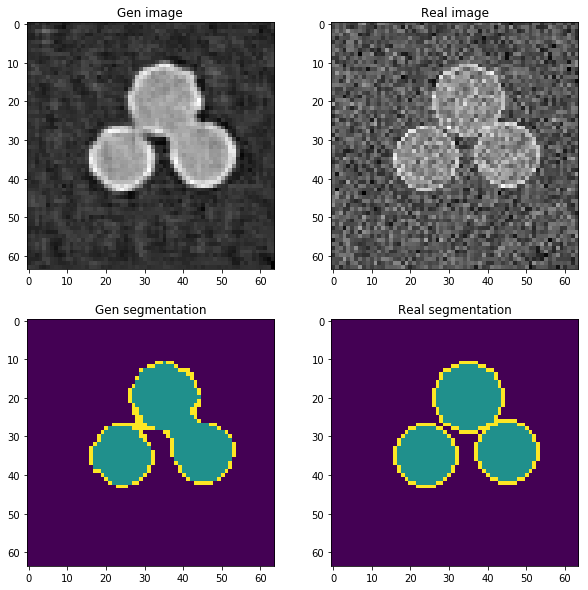

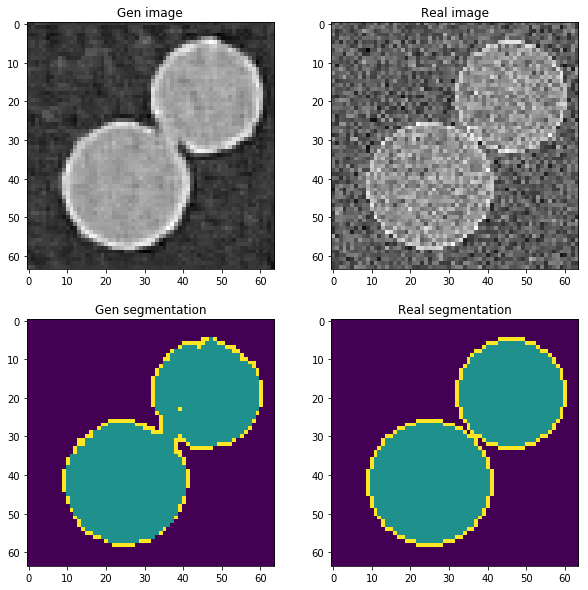

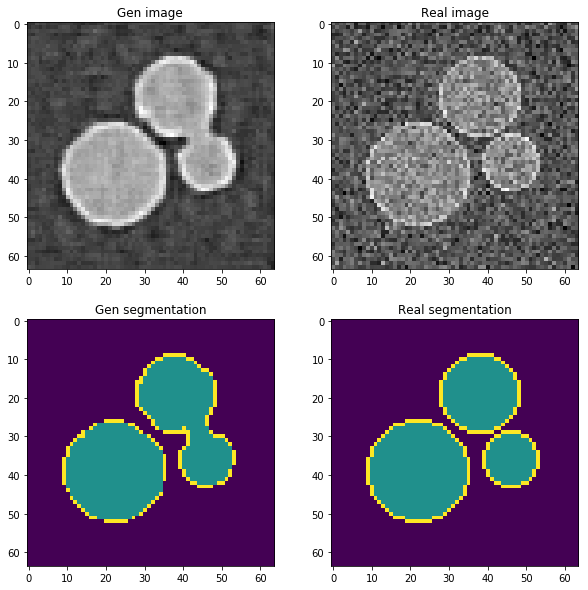

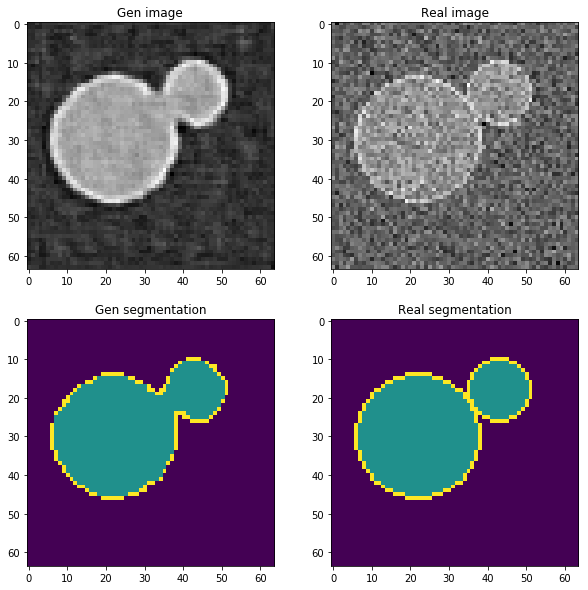

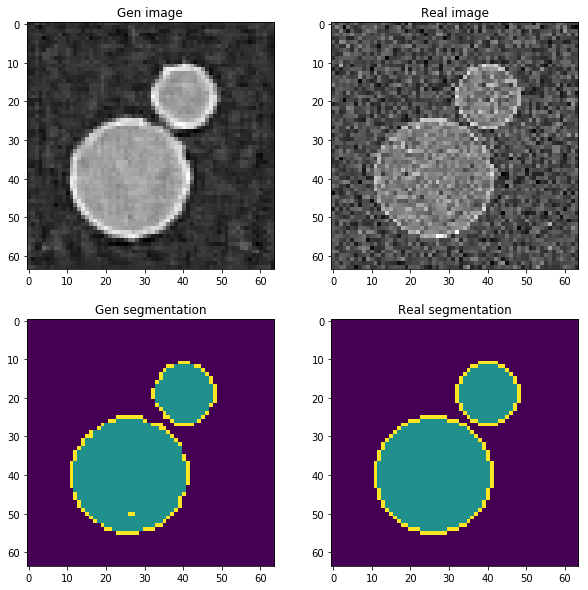

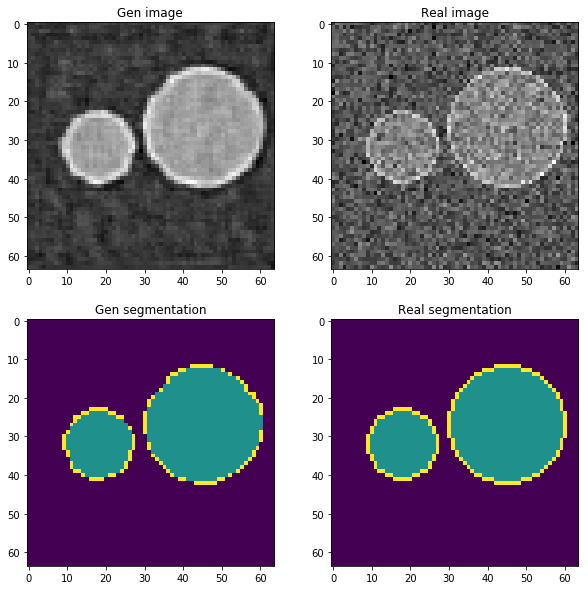

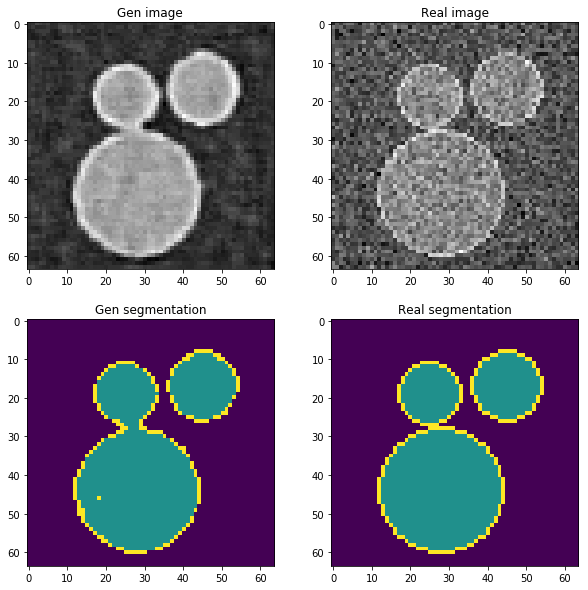

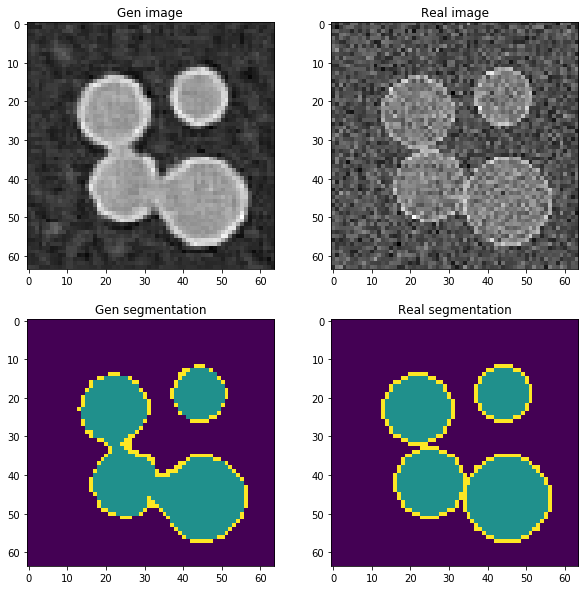

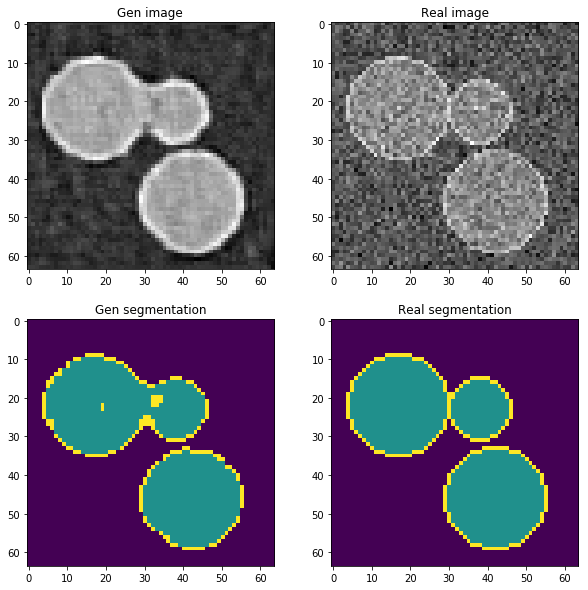

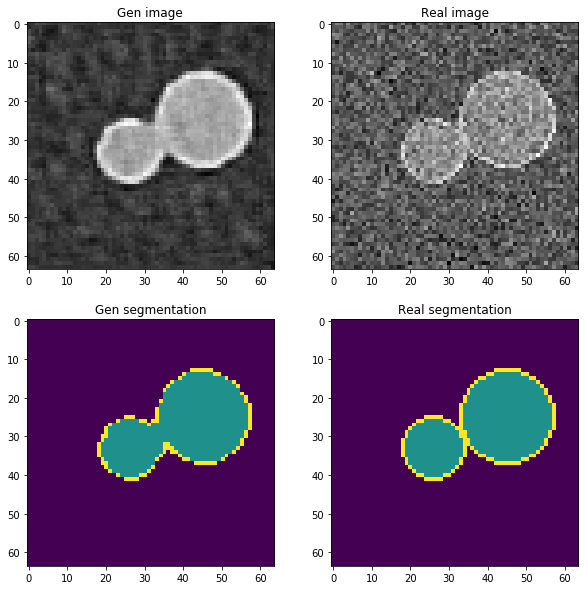

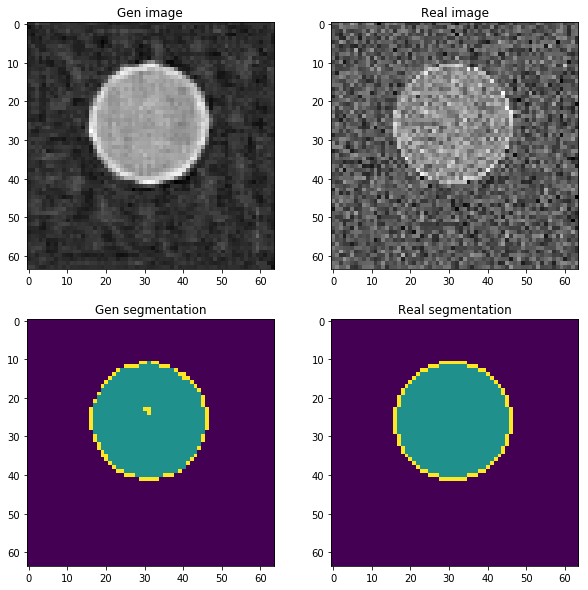

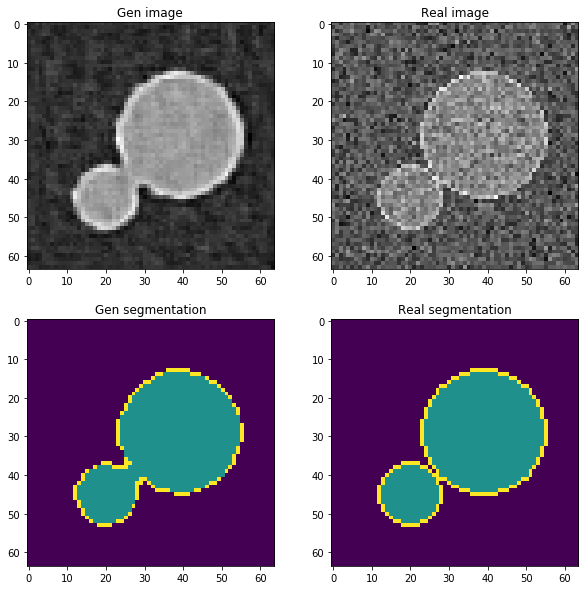

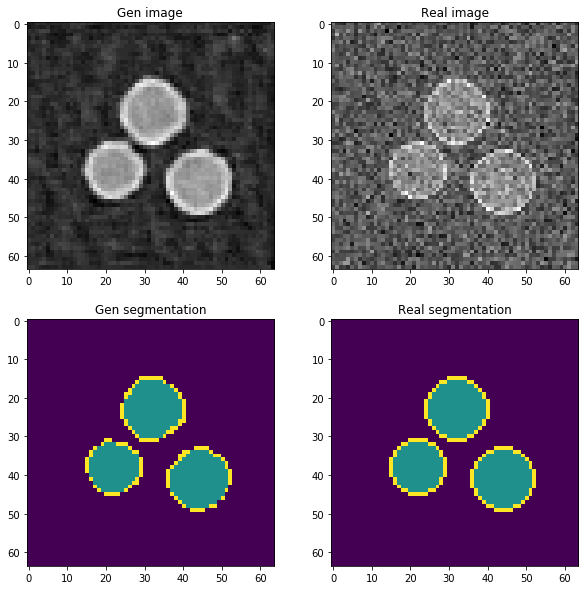

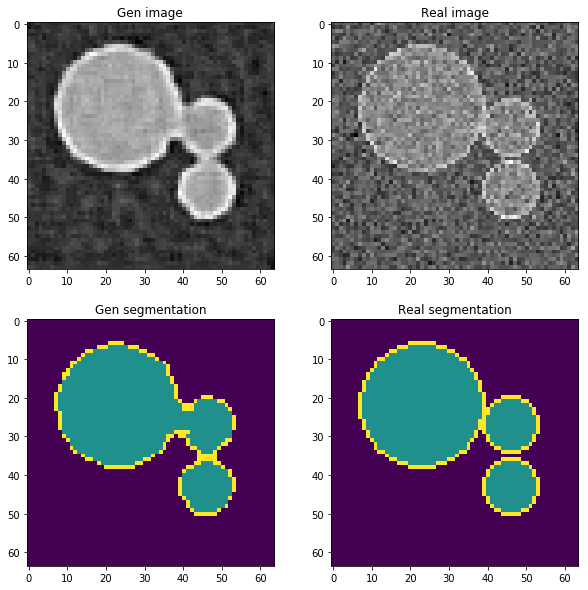

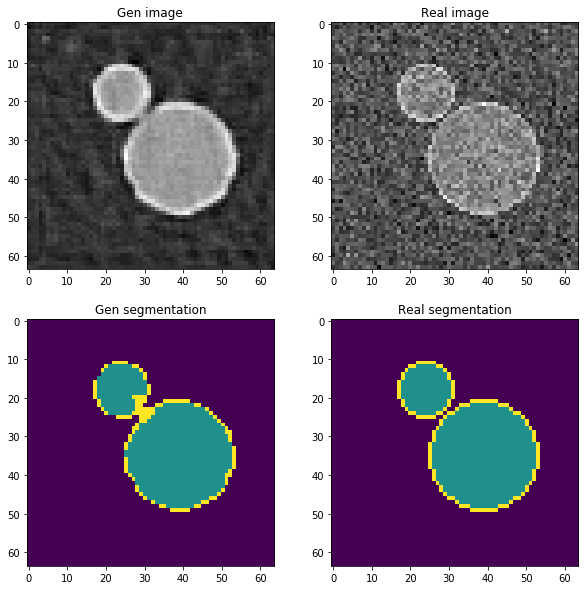

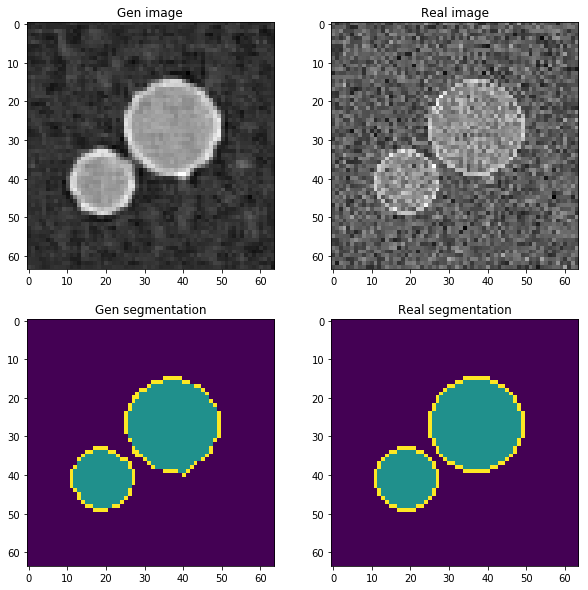

In [14]:
show_image_segm(img.data.numpy(), segm.data.numpy(), 
                train_images.data.numpy(), train_segmentation.data.numpy())

### generate test batch

In [15]:
test_batch_size = 5

In [16]:
test_images, test_segmentation = predata.get_train_batch(test_batch_size)

In [17]:
test_images = Variable(torch.from_numpy(test_images).float(), requires_grad=False)
test_segm = Variable(torch.from_numpy(test_segmentation), requires_grad=False)

In [18]:
z_test = Variable(torch.randn(test_batch_size, 3, 64, 64), requires_grad=True)

### Optimizing only latent variable z

In [19]:
optimizer = optim.Adam([z_test], lr=0.001)

test_loss = []
num_epochs = 300

for epoch in range(num_epochs):
    normalize_z(z_test)
    optimizer.zero_grad()   
    img, segm = net(z_test)
    loss = 1000 * img_loss(img, test_images)
    loss_epoch.append(loss.data)
    loss.backward()
    optimizer.step()
    print('epoch - {}, loss - {}'.format(epoch, loss.data.numpy()[0]))

normalize_z(z_test)

epoch - 0, loss - 7.242518424987793
epoch - 1, loss - 7.16150426864624
epoch - 2, loss - 7.081040382385254
epoch - 3, loss - 7.001335620880127
epoch - 4, loss - 6.922815799713135
epoch - 5, loss - 6.845186710357666
epoch - 6, loss - 6.768320083618164
epoch - 7, loss - 6.692440032958984
epoch - 8, loss - 6.6171088218688965
epoch - 9, loss - 6.5432658195495605
epoch - 10, loss - 6.471078872680664
epoch - 11, loss - 6.399707794189453
epoch - 12, loss - 6.328991413116455
epoch - 13, loss - 6.259579658508301
epoch - 14, loss - 6.1916632652282715
epoch - 15, loss - 6.124837875366211
epoch - 16, loss - 6.059108257293701
epoch - 17, loss - 5.994197845458984
epoch - 18, loss - 5.930180072784424
epoch - 19, loss - 5.866977691650391
epoch - 20, loss - 5.804800510406494
epoch - 21, loss - 5.743192195892334
epoch - 22, loss - 5.681923866271973
epoch - 23, loss - 5.621321678161621
epoch - 24, loss - 5.561324596405029
epoch - 25, loss - 5.502481937408447
epoch - 26, loss - 5.44463586807251
epoch - 27

epoch - 217, loss - 2.665375232696533
epoch - 218, loss - 2.6637938022613525
epoch - 219, loss - 2.6622233390808105
epoch - 220, loss - 2.6606669425964355
epoch - 221, loss - 2.6590983867645264
epoch - 222, loss - 2.6575405597686768
epoch - 223, loss - 2.655982255935669
epoch - 224, loss - 2.654447078704834
epoch - 225, loss - 2.652927875518799
epoch - 226, loss - 2.6514289379119873
epoch - 227, loss - 2.649949073791504
epoch - 228, loss - 2.648487091064453
epoch - 229, loss - 2.6470448970794678
epoch - 230, loss - 2.645627737045288
epoch - 231, loss - 2.6442079544067383
epoch - 232, loss - 2.642791509628296
epoch - 233, loss - 2.6413886547088623
epoch - 234, loss - 2.6399903297424316
epoch - 235, loss - 2.6385960578918457
epoch - 236, loss - 2.6371853351593018
epoch - 237, loss - 2.635787010192871
epoch - 238, loss - 2.6343812942504883
epoch - 239, loss - 2.6329805850982666
epoch - 240, loss - 2.631563901901245
epoch - 241, loss - 2.6301589012145996
epoch - 242, loss - 2.6287662982940

In [20]:
test_img, test_segm = net(z_test)

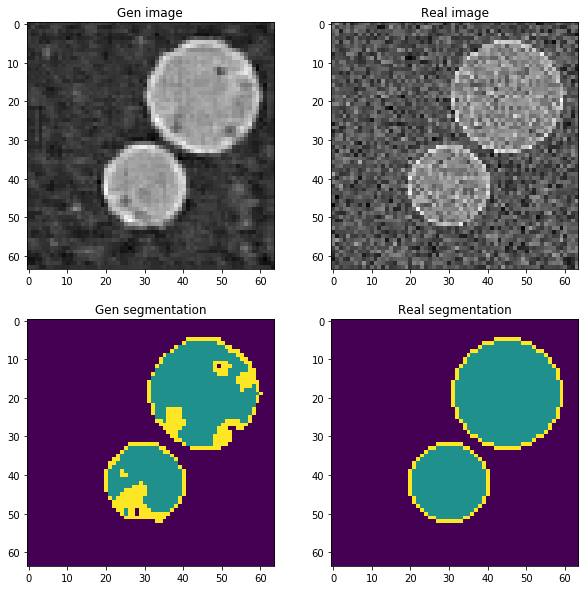

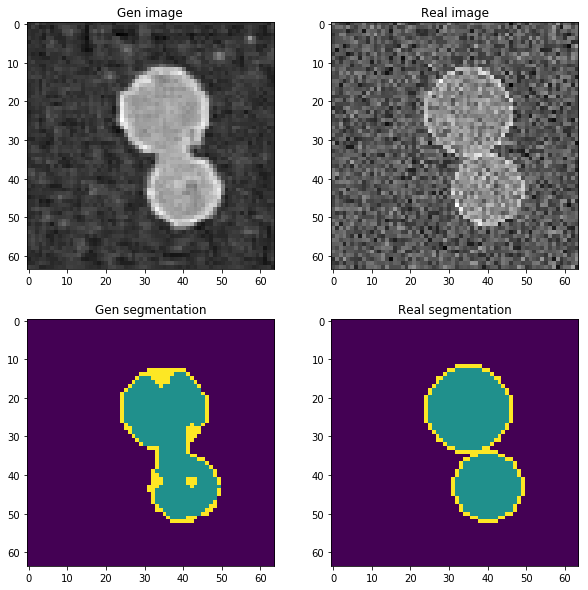

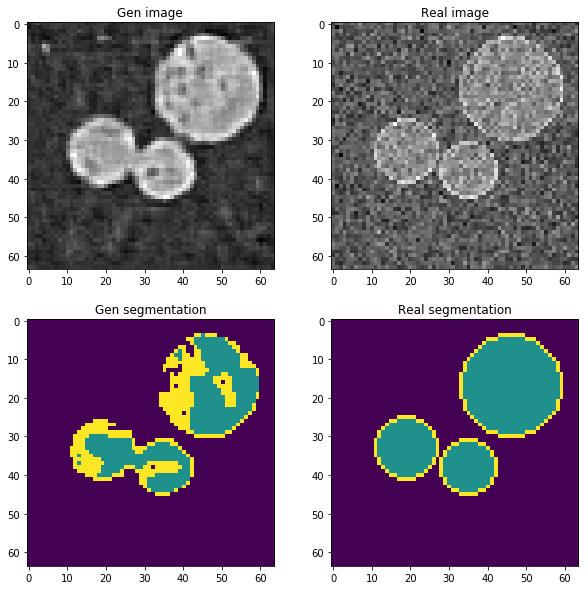

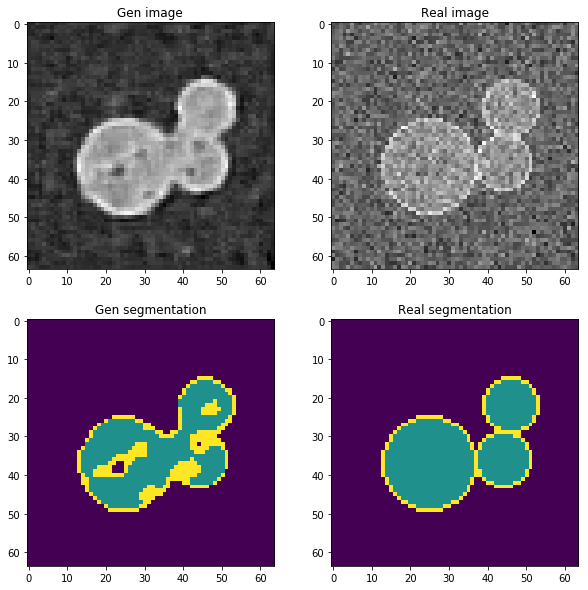

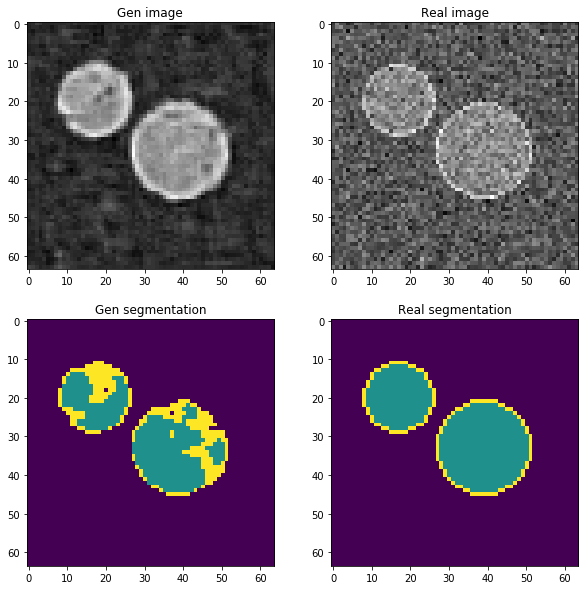

In [21]:
show_image_segm(test_img.data.numpy(), test_segm.data.numpy(), 
                test_images.data.numpy(), test_segmentation)